<a href="https://colab.research.google.com/github/ArjunNarayan2066/Test/blob/master/A2Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
!pip install ipympl
import ipympl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
# make it easier to understand by importing the required libraries within keras
from tensorflow.keras.layers import Dense, Flatten

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

np.random.seed(1)
np.set_printoptions(suppress=True)

     |████████████████████████████████| 112kB 7.4MB/s 


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
# Fetch the raw data once from the file
rawdata = np.genfromtxt('diabetes.csv', delimiter=',')
print(rawdata.shape)
data = rawdata[1:]
fields = data[:,:-1]
labels = data[:,-1].astype(np.int)
print(fields.shape)
print(labels.shape)


(769, 9)
(768, 8)
(768,)


In [9]:
# # Preprocess data into 80% of both 1 & 0 cases
# # Normalize data to between 1 & 0 in each field
# fields_max = fields.max(axis=0)
# norm_fields = fields / fields_max

# training_split = 0.8

# # Split into training & testing data
# label1_idx = np.where(labels == 1)[0]
# label0_idx = np.where(labels == 0)[0]
# label1_count = len(label1_idx)
# label0_count = len(label0_idx)
# train_size_1 = int(label1_count*training_split)
# train_size_0 = int(label0_count*training_split)

# # Fetch indices of training & testing data
# train_idx_1 = label1_idx[:train_size_1]
# train_idx_0 = label0_idx[:train_size_0]
# test_idx_1 = label1_idx[train_size_1:]
# test_idx_0 = label0_idx[train_size_0:]

# # Combine 1 & 0 cases to single array of indices
# train_idx = np.concatenate((train_idx_1, train_idx_0))
# test_idx = np.concatenate((test_idx_1, test_idx_0))

# # Final normalized & separated training & testing data
# train_data = norm_fields[train_idx]
# train_labels = labels[train_idx]
# test_data = norm_fields[test_idx]
# test_labels = labels[test_idx]

# print(train_data.shape)
# print(test_labels.shape)

In [10]:
# Normalize the data
norm_fields = (fields - fields.min(axis=0)) / (fields.max(axis=0) - fields.min(axis=0))

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)

# Split the data into training and testing
train_fields, test_fields, train_labels, test_labels = train_test_split(norm_fields, labels, test_size=0.20)

train_labels_enc = encoder.fit_transform(train_labels.reshape(-1,1))
test_labels_enc = encoder.fit_transform(test_labels.reshape(-1,1))

# print(train_labels)

print("Sample train data: {}".format(train_labels_enc[:3]))
print("Sample train labels: {}".format(test_labels_enc[:3]))

Sample train data: [[0. 1.]
 [0. 1.]
 [1. 0.]]
Sample train labels: [[1. 0.]
 [1. 0.]
 [1. 0.]]


In [11]:
# General training code for Question 3 functions

val_err_callback = keras.callbacks.EarlyStopping(monitor='val_loss', baseline=0.06, patience=200, mode="min") 
callbacks = [val_err_callback]

def train(model,K, lr = 0.005):
    best_history = None
    best_err = 1e6 # Something big
    fig_count = 0
    rolls = [len(s) for s in np.array_split(np.arange(len(labels)), K)]
    
    with tf.device('/device:GPU:0'):
        folded_fields = np.copy(train_fields)
        folded_labels = np.copy(train_labels_enc)

        # Apply K-fold cross validation
        val_split = 1.0/K
        for k in range(K):               
            model.compile(loss='categorical_crossentropy',  metrics=['accuracy'], 
                            optimizer=keras.optimizers.Adam(learning_rate=lr))
            # # Use the last 10% for validation            
            h = model.fit(folded_fields, folded_labels, 
                        epochs=1000, batch_size=1, validation_split=val_split, 
                        verbose=1)#, callbacks=callbacks)
            # Plot Results in Real Time
            plt.figure(fig_count)
            fig_count += 1
            plt.plot(h.history['loss'], 'b')
            plt.plot(h.history['val_loss'], 'r')
            plt.legend(['Training Loss', 'Validation Loss'])

            # Save the current values
            print("      Fold {} -- Train Err {} -- Val Err {}".format(k, h.history['loss'][-1], h.history['val_loss'][-1]))
            # Cycle the dataset, move the next 10% into the last spot to then cross-validate with the next fold
            folded_fields = np.roll(folded_fields, rolls[k])
            folded_labels = np.roll(folded_labels, rolls[k])

            if h.history['loss'][-1] < best_err:
                best_err = h.history['loss'][-1]
                best_history = h
        
    return best_history


### Model 1

In [12]:
%%time

model_1 = keras.models.Sequential([
    Dense(60, activation='sigmoid', input_shape=(8,)),
    Dense(40, activation='sigmoid'),
    Dense(20, activation='sigmoid'),
    # Dense(1, activation='linear')
    Dense(2, activation='softmax')
])
history = train(model_1, 5, lr=0.005)

Epoch 1/1000
491/491 [==============================] - 4s 2ms/step - loss: 0.6573 - accuracy: 0.6463 - val_loss: 0.6569 - val_accuracy: 0.6341
Epoch 2/1000
491/491 [==============================] - 1s 2ms/step - loss: 0.6697 - accuracy: 0.6363 - val_loss: 0.6713 - val_accuracy: 0.6341
Epoch 3/1000
491/491 [==============================] - 1s 2ms/step - loss: 0.6639 - accuracy: 0.6385 - val_loss: 0.6245 - val_accuracy: 0.6341
Epoch 4/1000
491/491 [==============================] - 1s 2ms/step - loss: 0.6028 - accuracy: 0.6761 - val_loss: 0.5945 - val_accuracy: 0.6341
Epoch 5/1000
491/491 [==============================] - 1s 2ms/step - loss: 0.5806 - accuracy: 0.6498 - val_loss: 0.5623 - val_accuracy: 0.7480
Epoch 6/1000
491/491 [==============================] - 1s 2ms/step - loss: 0.5439 - accuracy: 0.7223 - val_loss: 0.4747 - val_accuracy: 0.7561
Epoch 7/1000
491/491 [==============================] - 1s 2ms/step - loss: 0.5401 - accuracy: 0.6857 - val_loss: 0.4663 - val_accuracy:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

      Fold 0 -- Train Err 0.007488064933568239 -- Val Err 2.98088002204895
Epoch 1/1000
491/491 [==============================] - 2s 3ms/step - loss: 4.6663 - accuracy: 0.4934 - val_loss: 1.0981 - val_accuracy: 0.5122
Epoch 2/1000
491/491 [==============================] - 1s 2ms/step - loss: 0.9453 - accuracy: 0.5566 - val_loss: 1.0493 - val_accuracy: 0.5935
Epoch 3/1000
491/491 [==============================] - 1s 2ms/step - loss: 0.8417 - accuracy: 0.5693 - val_loss: 0.9604 - val_accuracy: 0.6260
Epoch 4/1000
491/491 [==============================] - 1s 2ms/step - loss: 0.7223 - accuracy: 0.6441 - val_loss: 0.9149 - val_accuracy: 0.6260
Epoch 5/1000
491/491 [==============================] - 1s 2ms/step - loss: 0.6762 - accuracy: 0.6525 - val_loss: 0.8973 - val_accuracy: 0.6504
Epoch 6/1000
491/491 [==============================] - 1s 2ms/step - loss: 0.7564 - accuracy: 0.5855 - val_loss: 0.9576 - val_accuracy: 0.6179
Epoch 7/1000
491/491 [==============================] - 1s 2m

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

      Fold 1 -- Train Err 0.10873935371637344 -- Val Err 3.853994369506836
Epoch 1/1000
491/491 [==============================] - 2s 3ms/step - loss: 7.7043 - accuracy: 0.5889 - val_loss: 6.2415 - val_accuracy: 0.5122
Epoch 2/1000
491/491 [==============================] - 1s 2ms/step - loss: 5.0576 - accuracy: 0.5928 - val_loss: 4.8717 - val_accuracy: 0.5610
Epoch 3/1000
491/491 [==============================] - 1s 2ms/step - loss: 4.1569 - accuracy: 0.5834 - val_loss: 3.6448 - val_accuracy: 0.6016
Epoch 4/1000
491/491 [==============================] - 1s 2ms/step - loss: 2.5740 - accuracy: 0.6225 - val_loss: 2.6843 - val_accuracy: 0.6179
Epoch 5/1000
491/491 [==============================] - 1s 2ms/step - loss: 2.2968 - accuracy: 0.5974 - val_loss: 2.5630 - val_accuracy: 0.5772
Epoch 6/1000
491/491 [==============================] - 1s 2ms/step - loss: 2.1561 - accuracy: 0.6236 - val_loss: 2.2080 - val_accuracy: 0.6260
Epoch 7/1000
491/491 [==============================] - 1s 2m

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

      Fold 2 -- Train Err 0.0343758687376976 -- Val Err 3.1665990352630615
Epoch 1/1000
491/491 [==============================] - 2s 3ms/step - loss: 4.8166 - accuracy: 0.6379 - val_loss: 2.4053 - val_accuracy: 0.5528
Epoch 2/1000
491/491 [==============================] - 1s 2ms/step - loss: 2.3346 - accuracy: 0.5379 - val_loss: 1.5386 - val_accuracy: 0.5610
Epoch 3/1000
491/491 [==============================] - 1s 2ms/step - loss: 1.2792 - accuracy: 0.5980 - val_loss: 1.0194 - val_accuracy: 0.5610
Epoch 4/1000
491/491 [==============================] - 1s 2ms/step - loss: 1.1508 - accuracy: 0.5863 - val_loss: 1.0522 - val_accuracy: 0.5935
Epoch 5/1000
491/491 [==============================] - 1s 3ms/step - loss: 1.0054 - accuracy: 0.5997 - val_loss: 1.1000 - val_accuracy: 0.5528
Epoch 6/1000
491/491 [==============================] - 1s 3ms/step - loss: 1.0340 - accuracy: 0.6018 - val_loss: 0.9149 - val_accuracy: 0.6585
Epoch 7/1000
491/491 [==============================] - 1s 2m

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

      Fold 3 -- Train Err 0.04170866683125496 -- Val Err 2.4429287910461426
Epoch 1/1000
491/491 [==============================] - 2s 3ms/step - loss: 4.2112 - accuracy: 0.5146 - val_loss: 1.7563 - val_accuracy: 0.5285
Epoch 2/1000
491/491 [==============================] - 1s 2ms/step - loss: 1.9409 - accuracy: 0.5302 - val_loss: 1.5463 - val_accuracy: 0.5528
Epoch 3/1000
491/491 [==============================] - 1s 3ms/step - loss: 1.7292 - accuracy: 0.4280 - val_loss: 1.3414 - val_accuracy: 0.5122
Epoch 4/1000
491/491 [==============================] - 1s 2ms/step - loss: 1.4132 - accuracy: 0.4627 - val_loss: 1.1245 - val_accuracy: 0.5772
Epoch 5/1000
491/491 [==============================] - 1s 3ms/step - loss: 1.1451 - accuracy: 0.4896 - val_loss: 1.0887 - val_accuracy: 0.4878
Epoch 6/1000
491/491 [==============================] - 1s 3ms/step - loss: 1.0140 - accuracy: 0.4966 - val_loss: 1.0428 - val_accuracy: 0.4797
Epoch 7/1000
491/491 [==============================] - 1s 3

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

      Fold 4 -- Train Err 0.6891012191772461 -- Val Err 3.598609685897827
CPU times: user 1h 40min 45s, sys: 15min 59s, total: 1h 56min 44s
Wall time: 1h 47min 19s


In [14]:
plt.figure(6)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

test_loss, test_acc = model_1.evaluate(test_fields,  test_labels_enc)
print('\nTest accuracy:', test_acc)
print('\nTest loss: ', test_loss)

5/5 [==============================] - 0s 3ms/step - loss: 30.5708 - accuracy: 0.3961

Test accuracy: 0.3961038887500763

Test loss:  30.570775985717773


### Model 2

Epoch 1/250
491/491 [==============================] - 1s 2ms/step - loss: 0.3343 - accuracy: 0.5621 - val_loss: 0.2145 - val_accuracy: 0.7561
Epoch 2/250
491/491 [==============================] - 1s 2ms/step - loss: 0.2518 - accuracy: 0.5812 - val_loss: 0.2250 - val_accuracy: 0.5447
Epoch 3/250
491/491 [==============================] - 1s 2ms/step - loss: 0.2133 - accuracy: 0.6808 - val_loss: 0.1866 - val_accuracy: 0.7886
Epoch 4/250
491/491 [==============================] - 1s 2ms/step - loss: 0.2005 - accuracy: 0.7016 - val_loss: 0.2690 - val_accuracy: 0.5447
Epoch 5/250
491/491 [==============================] - 1s 2ms/step - loss: 0.2228 - accuracy: 0.6324 - val_loss: 0.1919 - val_accuracy: 0.6748
Epoch 6/250
491/491 [==============================] - 1s 2ms/step - loss: 0.1951 - accuracy: 0.6941 - val_loss: 0.1783 - val_accuracy: 0.6829
Epoch 7/250
491/491 [==============================] - 1s 2ms/step - loss: 0.2036 - accuracy: 0.6937 - val_loss: 0.2199 - val_accuracy: 0.6179

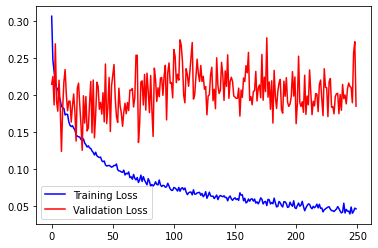

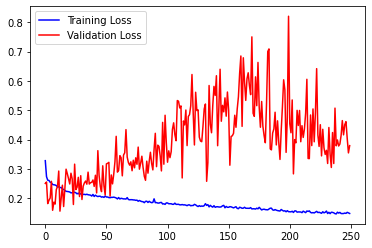

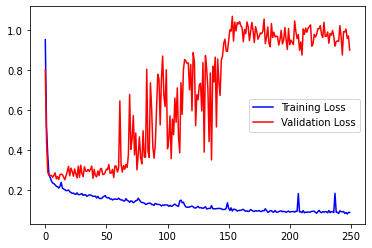

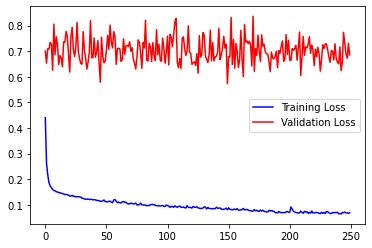

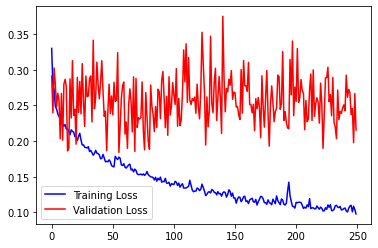

In [ ]:
%%time

model_2 = keras.models.Sequential([
    Dense(40, activation='sigmoid', input_shape=(8,)),
    Dense(20, activation='sigmoid'),
    Dense(1, activation='linear')
])
history = train(model_1, 5, 0.001)

5/5 [==============================] - 0s 3ms/step - loss: 1.7681 - accuracy: 0.4221

Test accuracy: 0.4220779240131378

Test loss:  1.768139123916626


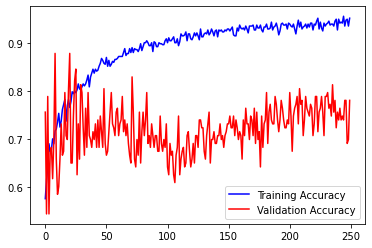

In [ ]:
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

test_loss, test_acc = model_1.evaluate(test_data,  test_labels)
print('\nTest accuracy:', test_acc)
print('\nTest loss: ', test_loss)